### Importing Libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

# Datetime
from datetime import datetime

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Large dataset
import dask.bag as db

In [2]:
# text preprocessing
import spacy
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import re
#import contractions
import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)
from sklearn.feature_extraction.text import CountVectorizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\risha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import pandas_profiling

In [4]:
reviews_df = pd.read_csv("sample30.csv")

In [5]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [6]:
reviews_df.shape

(30000, 15)

In [7]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### Missing Data Report

In [8]:
def get_missing_report(df):
    missing_df = (df.isnull().sum()/len(df)).rename_axis('columns').to_frame('missing_perc').reset_index()
    missing_df['missing_perc'] = missing_df['missing_perc'] * 100
    missing_df['type'] = missing_df['columns'].apply(lambda col: str(df[col].dtypes))
    return missing_df.sort_values(by = 'missing_perc', ascending=False)

In [9]:
get_missing_report(reviews_df)

,columns,missing_perc,type
12,reviews_userProvince,99.433333,object
11,reviews_userCity,93.570000,object
6,reviews_didPurchase,46.893333,object
7,reviews_doRecommend,8.566667,object
10,reviews_title,0.633333,object
3,manufacturer,0.470000,object
13,reviews_username,0.210000,object
5,reviews_date,0.153333,object
14,user_sentiment,0.003333,object
0,id,0.000000,object


Dropping Columns with more than 90% of the data missing and also because 'reviews_userProvince' and 'reviews_userCity' are of no use for sentiment analysis

In [10]:
features_to_remove = ['reviews_userProvince','reviews_userCity','reviews_date']
reviews_df.drop(features_to_remove,axis=1,inplace=True)

In [11]:
reviews_df.shape

(30000, 12)

In [12]:
# Replacing Nan values for remaining columns with appropriate names
reviews_df['reviews_didPurchase'].fillna(False,inplace=True)
reviews_df['reviews_doRecommend'].fillna(False,inplace=True)
reviews_df['reviews_title'].fillna('Unknown Title',inplace=True)
reviews_df['manufacturer'].fillna('Unknown manufacturer',inplace=True)
reviews_df['reviews_username'].fillna('Unknown username',inplace=True)

In [13]:
#Dropping reviews which doesn't have user sentiment
reviews_df = reviews_df[reviews_df['user_sentiment'].notna()]

In [14]:
reviews_df.shape

(29999, 12)

In [15]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29999 non-null  object
 1   brand                29999 non-null  object
 2   categories           29999 non-null  object
 3   manufacturer         29999 non-null  object
 4   name                 29999 non-null  object
 5   reviews_didPurchase  29999 non-null  bool  
 6   reviews_doRecommend  29999 non-null  bool  
 7   reviews_rating       29999 non-null  int64 
 8   reviews_text         29999 non-null  object
 9   reviews_title        29999 non-null  object
 10  reviews_username     29999 non-null  object
 11  user_sentiment       29999 non-null  object
dtypes: bool(2), int64(1), object(9)
memory usage: 2.6+ MB


In [16]:
#reviews_df['user_sentiment'] = reviews_df['user_sentiment'].astype('bool')

In [17]:
get_missing_report(reviews_df)

,columns,missing_perc,type
0,id,0.0,object
1,brand,0.0,object
2,categories,0.0,object
3,manufacturer,0.0,object
4,name,0.0,object
5,reviews_didPurchase,0.0,bool
6,reviews_doRecommend,0.0,bool
7,reviews_rating,0.0,int64
8,reviews_text,0.0,object
9,reviews_title,0.0,object


In [18]:
##########################################
## DESCRIPTIVE STATISTICS
##########################################

print ("================================================")

### Total reviews
total = len(reviews_df)
print ("Number of reviews: ",total)
print ()

### How many unique reviewers?
print ("Number of unique reviewers: ",len(reviews_df.id.unique()))
reviewer_prop = float(len(reviews_df.id.unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))
print ()

### How many unique products?
print ("Number of unique products: ", len(reviews_df.name.unique()))
product_prop = float(len(reviews_df.name.unique())/total)
print ("Prop of unique products: ",round(product_prop,3))
print ()

### Average star score
print ("Average rating score: ",round(reviews_df.reviews_rating.mean(),3))


print ("================================================")

Number of reviews:  29999

Number of unique reviewers:  271
Prop of unique reviewers:  0.009

Number of unique products:  271
Prop of unique products:  0.009

Average rating score:  4.483


Text(0, 0.5, 'Number of Reviews')

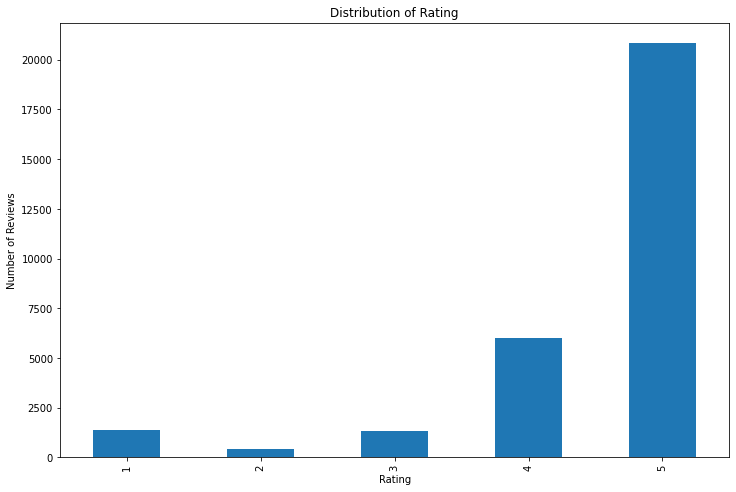

In [19]:
##########################################
## PLOT DISTRIBUTION OF RATING 
##########################################

plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
reviews_df['reviews_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

In [20]:
reviews_df['user_sentiment'].value_counts(normalize=True)

Positive    0.887763
Negative    0.112237
Name: user_sentiment, dtype: float64

In [21]:
pandas_profiling.ProfileReport(reviews_df)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
##########################################
## CONCATENATE REVIEWTEXT AND SUMMARY 
##########################################

reviews_df['review'] = reviews_df[['reviews_title', 'reviews_text']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)
reviews_df = reviews_df.drop(['reviews_title', 'reviews_text'], axis = 1)
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),False,False,5,joshua,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,rebecca,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,walker557,Negative,Irritation My husband bought this gel for us. ...


In [23]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(reviews_df['reviews_username'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(reviews_df['name'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(reviews_df)/len(reviews_df['reviews_username'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(reviews_df)/len(reviews_df['name'].unique()))))


Number of unique customers : 24915

Number of unique products : 271

Review per customer: 1.20405378286173

Review per product: 110.69741697416974


### Text Preprocessing
The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

In [20]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import unicodedata
import contractions
#from contractions import CONTRACTION_MAP
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\risha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\risha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\risha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# calculate raw tokens in order to measure of cleaned tokens

from nltk.tokenize import word_tokenize
raw_tokens=len([w for t in (reviews_df["review"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 1274211


### Lemmatization
The process of lemmatization is to remove word affixes to get to a base form of the word. The base form is also known as the root word, or the lemma, will always be present in the dictionary.

In [22]:
import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

In [23]:
from contractions import contractions_dict

In [24]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text



# # Define function to expand contractions
# def expand_contractions(text):
#     contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),flags=re.IGNORECASE|re.DOTALL)
#     def expand_match(contraction):
#         match = contraction.group(0)
#         first_char = match[0]
#         expanded_contraction = contractions_dict.get(match)\
#                         if contractions_dict.get(match)\
#                         else contractions_dict.get(match.lower())
#         expanded_contraction = first_char+expanded_contraction[1:]
#         return expanded_contraction
    
#     expanded_text = contractions_pattern.sub(expand_match, text)
#     expanded_text = re.sub("'", "", expanded_text)
#     return expanded_text


# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words


def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
#stopword_list.remove('headphone')
#stopword_list.remove('headphones')
#stopword_list.remove('earbuds')
#stopword_list.remove('bud')
#stopword_list.remove('ear')
#stopword_list.remove('sony')
#stopword_list.remove('product')


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [25]:
def normalize_and_lemmaize(input):
    sample = denoise_text(input)
    #sample = expand_contractions(sample)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [26]:
reviews_df['review_cleaned'] = reviews_df['review'].map(lambda text: normalize_and_lemmaize(text))

In [27]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review,review_cleaned
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),False,False,5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor.,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,rebecca,Negative,Disappointed I read through the reviews on her...,disappoint read review look buy one couple lub...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,walker557,Negative,Irritation My husband bought this gel for us. ...,irritation husband buy gel us gel cause irrita...


### Cleaning the Text

In [28]:
# Let's put aside number of raw tokens in order to measure of cleaned tokens
from nltk.tokenize import word_tokenize
clean_tokens=len([w for t in (reviews_df["review_cleaned"].apply(word_tokenize)) for w in t])
#clean_tokens=len((product_reviews_hp4["clean_text"]))
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 599695

Percentage of removed tokens: 0.53


In [29]:
from nltk.tokenize import RegexpTokenizer
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

ListWords = []
for m in reviews_df['review_cleaned']:
    n = RegExpTokenizer(str(m))
    ListWords.append(n)
print(ListWords[10])

['pretty', 'dissapoitned', 'try', 'husband', 'felt', 'no', 'different', 'no', 'effect', 'no', 'change', 'first', 'te', 'use', 'ky', 'gel', 'not', 'sure', 'want', 'try', 'others']


In [30]:
#All Words
from nltk import FreqDist
def Bag_Of_Words(ListWords):
    all_words = []
    for m in ListWords:
        for w in m:
            all_words.append(w.lower())
    all_words1 = FreqDist(all_words)
    return all_words1

Combien de Mots !!! 18169


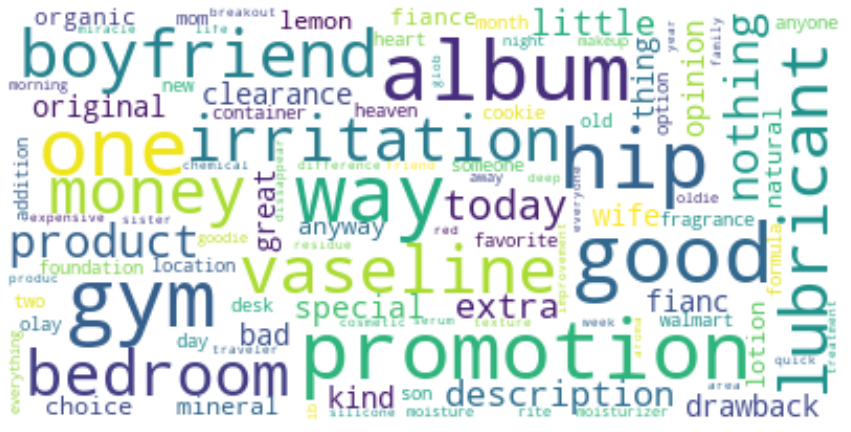

In [35]:
import matplotlib as mpl
from wordcloud import WordCloud
all_words = Bag_Of_Words(ListWords)
ax = plt.figure(figsize=(15,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',max_font_size=40).generate(' '.join(all_words.keys()))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Combien de Mots !!!",len(all_words))

<AxesSubplot:>

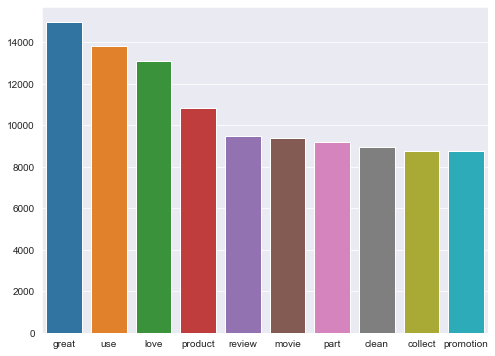

In [52]:
plt.figure(figsize = (8,6))
import seaborn as sns
from sklearn.manifold import TSNE
all_words = Bag_Of_Words(ListWords)
count = []
Words  = []
for w in all_words4.most_common(10):
    count.append(w[1])
    Words.append(w[0])
sns.set_style("darkgrid")
sns.barplot(Words,count)

Text(0, 0.5, 'Number of Reviews')

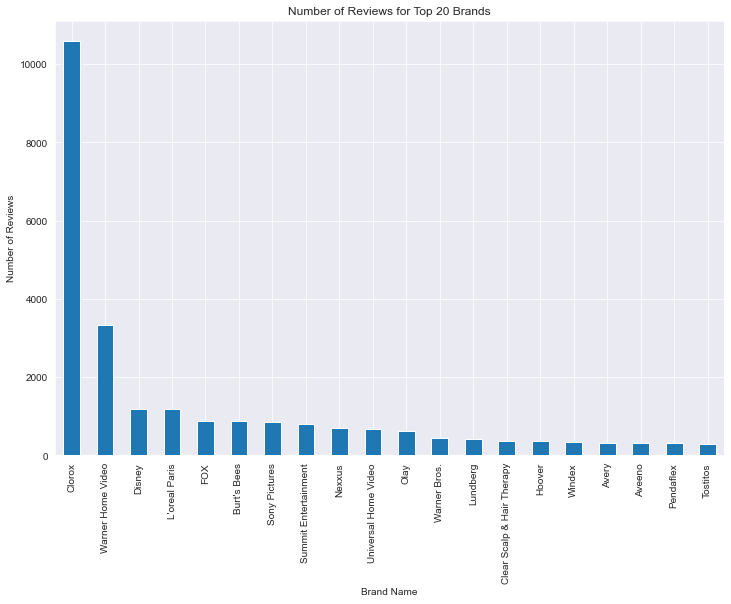

In [55]:
##########################################
## PLOT NUMBER OF REVIEWS FOR TOP 20 BRANDS  
##########################################

brands = reviews_df["brand"].value_counts()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

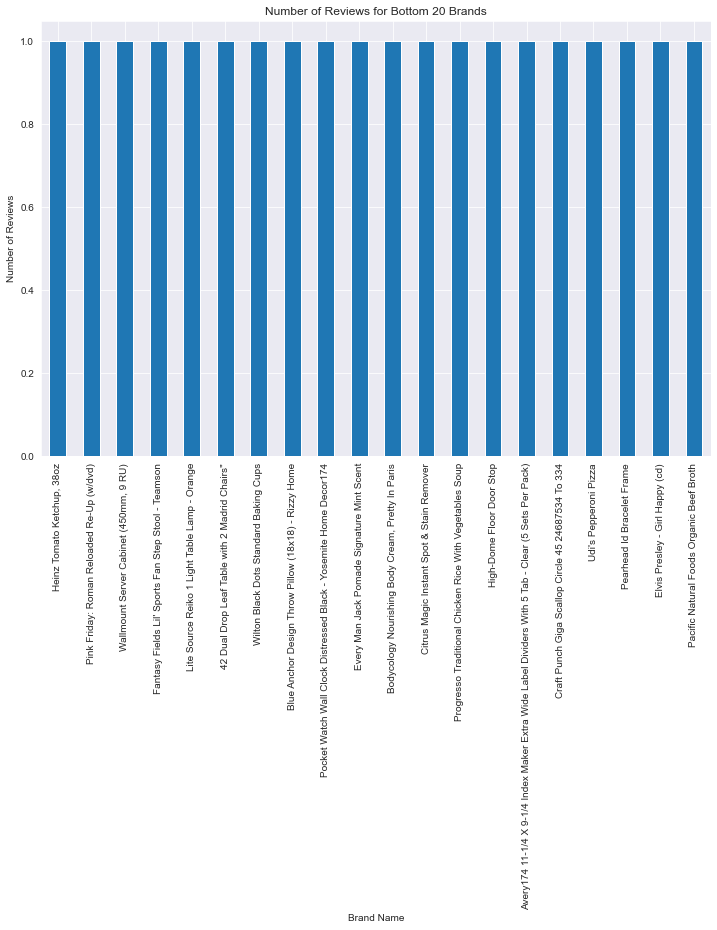

In [54]:
##########################################
## PLOT NUMBER OF REVIEWS FOR BOTTOM 20 BRANDS  
##########################################

brands = reviews_df["name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[-20:].plot(kind='bar')
plt.title("Number of Reviews for Bottom 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

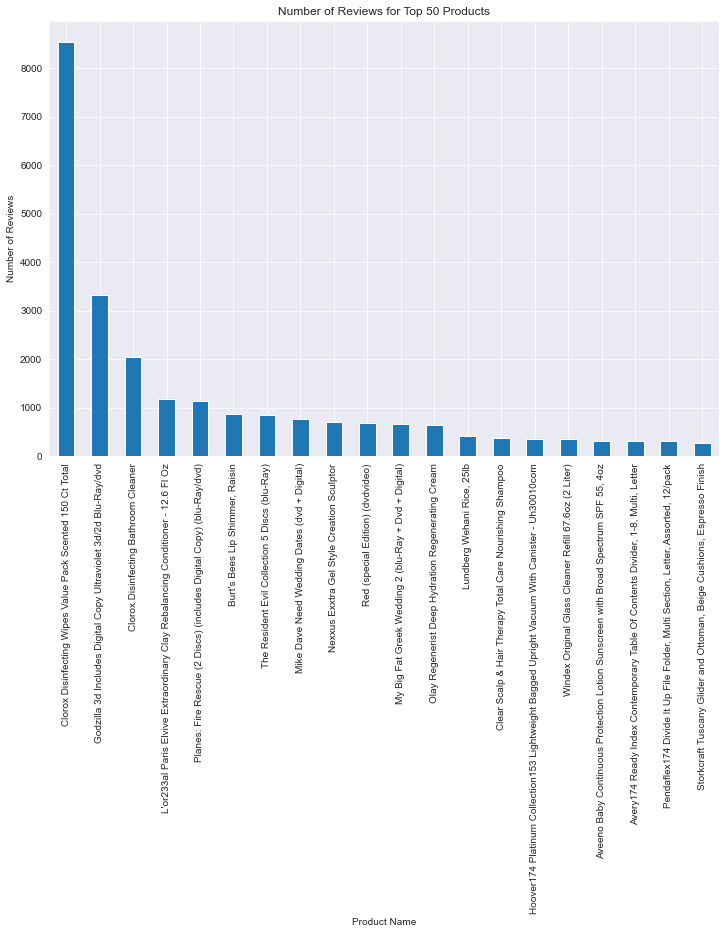

In [56]:
##########################################
## PLOT NUMBER OF REVIEWS FOR TOP 20 PRODUCTS  
##########################################

products = reviews_df["name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")
plt.xlabel('Product Name')
plt.ylabel('Number of Reviews')

In [57]:
low_rating_reviews_df = reviews_df[reviews_df['reviews_rating'] < 3]

Text(0, 0.5, 'Number of Reviews')

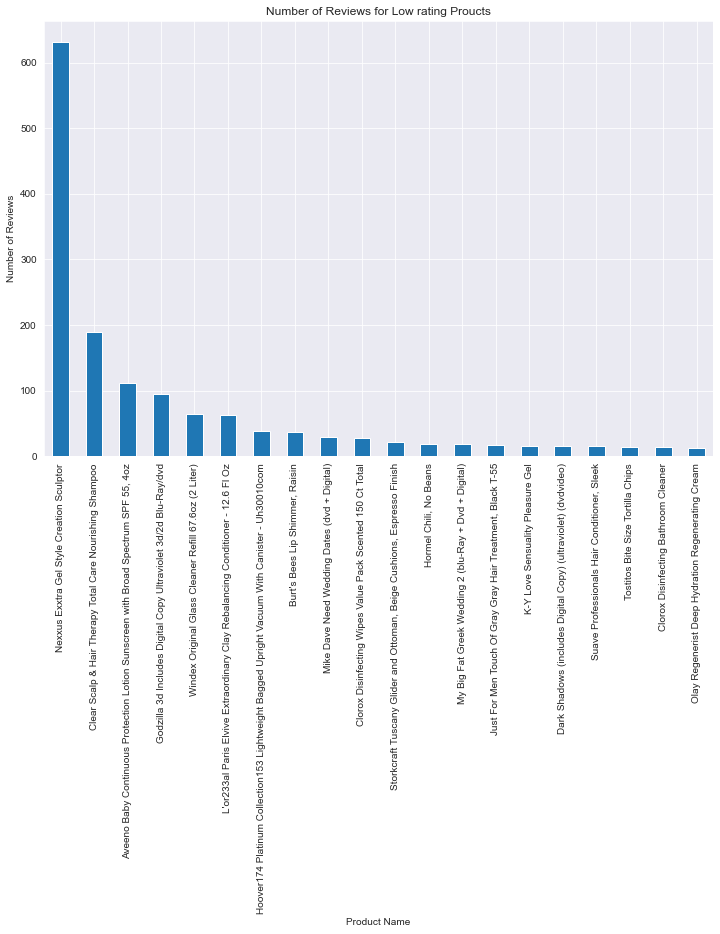

In [59]:
##########################################
## PLOT NUMBER OF REVIEWS FOR LOW RATING PRODUCTS  
##########################################

products = low_rating_reviews_df["name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for Low rating Proucts")
plt.xlabel('Product Name')
plt.ylabel('Number of Reviews')

In [31]:
# Function for creating a column token
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

# To create token feature
reviews_df['token'] = reviews_df['review_cleaned'].apply(token)

In [32]:
# Function for creating a column to see the length of the review text
def length(text):
    length = len([w for w in nltk.word_tokenize(text)])
    return length

# Apply length function to create review length feature
reviews_df['review_length'] = reviews_df['review'].apply(length)
reviews_df.head(3)

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review,review_cleaned,token,review_length
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),False,False,5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...,"[awesome, love, album, good, hip, hop, side, c...",51
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion,"[good, good, flavor, review, collect, part, pr...",14
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor.,good good flavor,"[good, good, flavor]",4


### Sentiment Analysis (CV-TF_IDF-HASH)

In [33]:
import unicodedata
from nltk.tokenize import ToktokTokenizer
import spacy
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [34]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [35]:
from collections import Counter

In [36]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [38]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29999 non-null  object
 1   brand                29999 non-null  object
 2   categories           29999 non-null  object
 3   manufacturer         29999 non-null  object
 4   name                 29999 non-null  object
 5   reviews_didPurchase  29999 non-null  bool  
 6   reviews_doRecommend  29999 non-null  bool  
 7   reviews_rating       29999 non-null  int64 
 8   reviews_username     29999 non-null  object
 9   user_sentiment       29999 non-null  object
 10  review               29999 non-null  object
 11  review_cleaned       29999 non-null  object
 12  token                29999 non-null  object
 13  review_length        29999 non-null  int64 
dtypes: bool(2), int64(2), object(10)
memory usage: 3.0+ MB


In [39]:
reviews_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_username', 'user_sentiment', 'review', 'review_cleaned',
       'token', 'review_length'],
      dtype='object')

In [40]:
#Dropping unncessary columns
reviews_df_final = reviews_df[['name','reviews_rating',
       'reviews_username', 'user_sentiment', 'review', 'review_cleaned',
       'token']]

In [45]:
reviews_df_final.head()

,name,reviews_rating,reviews_username,user_sentiment,review,review_cleaned,token
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...,"[awesome, love, album, good, hip, hop, side, c..."
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion,"[good, good, flavor, review, collect, part, pr..."
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor.,good good flavor,"[good, good, flavor]"
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,Disappointed I read through the reviews on her...,disappoint read review look buy one couple lub...,"[disappoint, read, review, look, buy, one, cou..."
4,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,Irritation My husband bought this gel for us. ...,irritation husband buy gel us gel cause irrita...,"[irritation, husband, buy, gel, us, gel, cause..."


### Natural Language Processing

### Data Preprocessing

In [42]:
reviews_df_final['user_sentiment'] = reviews_df_final['user_sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [43]:
# Splitting the Data Set into Train and Test Sets
X = reviews_df_final['review_cleaned']
y = reviews_df_final['user_sentiment']

### Splitting Dataset into Train and Test Set
We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [44]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(22499,)
Test Set Shape		:(7500,)


In [46]:
y_train.value_counts()/len(y_train)

1    0.886751
0    0.113249
Name: user_sentiment, dtype: float64

In [47]:
y_test.value_counts()/len(y_test)

1    0.8908
0    0.1092
Name: user_sentiment, dtype: float64

### Selecting the Right Evaluation Metric
Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

### Confusion Matrix Plot Function
Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [49]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

### Modelling
This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

### CountVectorizer Bag of Words
We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class.

In [50]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(stop_words='english',max_features = 5000)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [51]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 5000


In [52]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [53]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,aaron,abilities,ability,able,abrasive,absolute,absolutely,absolutly,absorb,academy,...,zac,zach,zero,zilla,zinc,zip,ziploc,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Handling class imbalance using SMOTE based techniques

### A) SMOTE Technique

In [54]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(count_vect_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 19951, 0: 2548})
After Counter({1: 19951, 0: 19951})


In [55]:
def modeling(Model,params, Xtrain,y_train):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
      # Instantiate the classifier: model
    clf_model = Model

    cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

    # Create grid search using 5-fold cross validation
    clf_model = GridSearchCV(model, params, cv=cv, scoring='roc_auc', n_jobs=-1,verbose=True)
    clf_model.fit(Xtrain, y_train)
    print(clf_model.best_estimator_)
    return clf_model

In [59]:
model_cv = list()
resample_cv = list()
precision_cv = list()
precision_neg_cv = list()
recall_neg_cv = list()
recall_cv = list()
F1score_cv = list()
AUCROC_cv = list()

In [60]:
def get_recall_negative_class(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = matrix
    recall_neg = tn / (tn + fp)
    return recall_neg

def get_precision_negative_class(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = matrix
    precision_neg = tn / (tn + fn)
    return precision_neg

In [61]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
    score = f1_score(y_test, y_pred, average = 'weighted')
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
          
    model_cv.append(algo)
    precision_cv.append(precision_score(y_test,y_pred))
    recall_cv.append(recall_score(y_test,y_pred))
    F1score_cv.append(score)
    AUCROC_cv.append(roc_auc_score(y_test, y_prob[:,1]))
    resample_cv.append(sampling)
    precision_neg_cv.append(get_precision_negative_class(y_test,y_pred))
    recall_neg_cv.append(get_recall_negative_class(y_test,y_pred))

### Logistic Regression with Count Vectorizer

1. Original Unsampled Data

In [63]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
# params={'C':[-2,0.1,1,10],'class_weight':[None,'balanced'],'penalty':['l1','l2']}
#clf_LR_countvec_unsampled = modeling(LogisticRegression(solver = 'newton-cg',random_state=100),params,count_vect_train,y_train)

In [ ]:
# LR_model = LogisticRegression(solver = 'newton-cg',random_state=100)
# cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# # Create grid search using 5-fold cross validation
# clf_LR_countvec_unsampled = GridSearchCV(LR_model, params, cv=cv, scoring='roc_auc', n_jobs=-1,verbose=True)
# clf_LR_countvec_unsampled.fit(count_vect_train, y_train)
# print(clf_model.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min


In [58]:
clf_LR_countvec = LogisticRegression(solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.3, random_state = 100,verbose=3,n_jobs=-1)

In [62]:
clf_LR_countvec.fit(count_vect_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished


LogisticRegression(C=0.3, class_weight='balanced', n_jobs=-1, random_state=100,
                   solver='newton-cg', verbose=3)

In [63]:
test_eval(clf_LR_countvec,count_vect_test,y_test,'Linear Regression CountVec','actual')

Confusion Matrix
[[ 668  151]
 [ 846 5835]] 

Classification Report
              precision    recall  f1-score   support

           0       0.44      0.82      0.57       819
           1       0.97      0.87      0.92      6681

    accuracy                           0.87      7500
   macro avg       0.71      0.84      0.75      7500
weighted avg       0.92      0.87      0.88      7500
 

AUC-ROC
0.928828842165169
f1 score: 0.8832202416402672


In [64]:
clf_LR_countvec.fit(X_train_sm,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.1min finished


LogisticRegression(C=0.3, class_weight='balanced', n_jobs=-1, random_state=100,
                   solver='newton-cg', verbose=3)

In [66]:
test_eval(clf_LR_countvec,count_vect_test,y_test,'Linear Regression CountVec','SMOTE')

Confusion Matrix
[[ 534  285]
 [ 524 6157]] 

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.65      0.57       819
           1       0.96      0.92      0.94      6681

    accuracy                           0.89      7500
   macro avg       0.73      0.79      0.75      7500
weighted avg       0.91      0.89      0.90      7500
 

AUC-ROC
0.8987552220601165
f1 score: 0.898018460359751


### Random Forest with Countvectorizer

In [76]:
clf_RF_countvec = RandomForestClassifier(n_estimators = 200, random_state = 100,max_depth=8,n_jobs=-1,min_samples_split=10,verbose=3)

In [77]:
clf_RF_countvec.fit(count_vect_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200
building tree 4 of 200

building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.5s


building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min


building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=100, verbose=3)

In [78]:
test_eval(clf_RF_countvec,count_vect_test,y_test,'Random Forest CountVec','actual')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.6s


Confusion Matrix
[[ 268  551]
 [  83 6598]] 

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.33      0.46       819
           1       0.92      0.99      0.95      6681

    accuracy                           0.92      7500
   macro avg       0.84      0.66      0.71      7500
weighted avg       0.91      0.92      0.90      7500
 

AUC-ROC
0.8886588888834062
f1 score: 0.8999902819956616


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.0s finished


In [79]:
clf_RF_countvec.fit(X_train_sm,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.8s


building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min


building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.9min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=100, verbose=3)

In [80]:
test_eval(clf_RF_countvec,count_vect_test,y_test,'Random Forest','SMOTE')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s


Confusion Matrix
[[ 445  374]
 [ 378 6303]] 

Classification Report
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       819
           1       0.94      0.94      0.94      6681

    accuracy                           0.90      7500
   macro avg       0.74      0.74      0.74      7500
weighted avg       0.90      0.90      0.90      7500
 

AUC-ROC
0.894385952984965
f1 score: 0.8998404485927587


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


### Naive Bayes with Countvectorizer

In [81]:
clf_nb_countvec = MultinomialNB()

In [82]:
clf_nb_countvec.fit(count_vect_train, y_train)

MultinomialNB()

In [83]:
test_eval(clf_nb_countvec,count_vect_test,y_test,'Naive Bayes','actual')

Confusion Matrix
[[ 274  545]
 [ 427 6254]] 

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.33      0.36       819
           1       0.92      0.94      0.93      6681

    accuracy                           0.87      7500
   macro avg       0.66      0.64      0.64      7500
weighted avg       0.86      0.87      0.87      7500
 

AUC-ROC
0.8468053757681059
f1 score: 0.8659367140402936


In [84]:
clf_nb_countvec.fit(X_train_sm,y_train_sm)

MultinomialNB()

In [85]:
test_eval(clf_nb_countvec,count_vect_test,y_test,'Naive Bayes','SMOTE')

Confusion Matrix
[[ 403  416]
 [ 952 5729]] 

Classification Report
              precision    recall  f1-score   support

           0       0.30      0.49      0.37       819
           1       0.93      0.86      0.89      6681

    accuracy                           0.82      7500
   macro avg       0.61      0.67      0.63      7500
weighted avg       0.86      0.82      0.84      7500
 

AUC-ROC
0.7679265220800919
f1 score: 0.8362741142036837


### XGBoost with Countvectorizer

In [88]:
clf_XGB_countvec = XGBClassifier(n_jobs=-1,verbose=3)

In [89]:
clf_XGB_countvec.fit(count_vect_train, y_train)

[01:10:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=3,
              verbosity=None)

In [90]:
test_eval(clf_XGB_countvec,count_vect_test,y_test,'XGBoost','actual')

Confusion Matrix
[[ 315  504]
 [ 135 6546]] 

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.38      0.50       819
           1       0.93      0.98      0.95      6681

    accuracy                           0.91      7500
   macro avg       0.81      0.68      0.72      7500
weighted avg       0.90      0.91      0.90      7500
 

AUC-ROC
0.9210785638715588
f1 score: 0.9035575769690264


In [91]:
clf_XGB_countvec.fit(X_train_sm,y_train_sm)

[01:12:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=3,
              verbosity=None)

In [92]:
test_eval(clf_XGB_countvec,count_vect_test,y_test,'XGBoost','SMOTE')

Confusion Matrix
[[ 536  283]
 [ 602 6079]] 

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.65      0.55       819
           1       0.96      0.91      0.93      6681

    accuracy                           0.88      7500
   macro avg       0.71      0.78      0.74      7500
weighted avg       0.90      0.88      0.89      7500
 

AUC-ROC
0.8980030845769507
f1 score: 0.8901742750904783


In [96]:
clf_eval_df = pd.DataFrame({'model':model_cv,
                            'resample':resample_cv,
                            'precision':precision_cv,
                            'recall':recall_cv,
                            'f1-score':F1score_cv,
                            'AUC-ROC':AUCROC_cv,
                           'recall_neg':recall_neg_cv,
                           'precision_neg':precision_neg_cv})

In [97]:
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC,recall_neg,precision_neg
0,Linear Regression CountVec,actual,0.974774,0.873372,0.883220,0.928829,0.815629,0.441215
1,Linear Regression CountVec,SMOTE,0.955759,0.921569,0.898018,0.898755,0.652015,0.504726
2,Random Forest CountVec,actual,0.890800,1.000000,0.839353,0.843682,0.000000,NaN
3,Random Forest CountVec,actual,0.890800,1.000000,0.839353,0.835884,0.000000,NaN
4,Random Forest CountVec,actual,0.890800,1.000000,0.839353,0.837775,0.000000,NaN
5,Random Forest CountVec,actual,0.922926,0.987577,0.899990,0.888659,0.327228,0.763533
6,Random Forest,SMOTE,0.943987,0.943422,0.899840,0.894386,0.543346,0.540705
7,Naive Bayes,actual,0.919841,0.936087,0.865937,0.846805,0.334554,0.390870
8,Naive Bayes,SMOTE,0.932303,0.857506,0.836274,0.767927,0.492063,0.297417
9,XGBoost,actual,0.928511,0.979793,0.903558,0.921079,0.384615,0.700000


In [85]:
model_cv

[]

### TF IDF

In [98]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1),max_features=5000)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [102]:
model_tf_idf = list()
resample_tf_idf = list()
precision_tf_idf = list()
precision_neg_tf_idf = list()
recall_neg_tf_idf = list()
recall_tf_idf = list()
F1score_tf_idf = list()
AUCROC_tf_idf = list()

In [103]:
def test_eval_tf_idf(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
    score = f1_score(y_test, y_pred, average = 'weighted')
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
          
    model_tf_idf.append(algo)
    precision_tf_idf.append(precision_score(y_test,y_pred))
    recall_tf_idf.append(recall_score(y_test,y_pred))
    F1score_tf_idf.append(score)
    AUCROC_tf_idf.append(roc_auc_score(y_test, y_prob[:,1]))
    resample_tf_idf.append(sampling)
    precision_neg_tf_idf.append(get_precision_negative_class(y_test,y_pred))
    recall_neg_tf_idf.append(get_recall_negative_class(y_test,y_pred))

In [99]:
# Assign feature names of vector into a variable
vocab = tfidf_vect.get_feature_names()

In [100]:
pd.DataFrame(tfidf_vect_train, columns = vocab).head()

,aaron,abilities,ability,able,abrasive,absences,absolute,absolutely,absolutley,absolutly,...,zinc,zing,zip,ziploc,ziplock,zipper,zombie,zombies,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression with TF IDF

In [101]:
clf_LR_TF_IDF = LogisticRegression(solver = 'newton-cg',class_weight = 'balanced', 
                                                   C = 0.1, n_jobs = -1, random_state = 42,verbose=3)

In [104]:
clf_LR_TF_IDF.fit(tfidf_vect_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='newton-cg', verbose=3)

In [105]:
test_eval_tf_idf(clf_LR_TF_IDF,tfidf_vect_test, y_test,'Logistic Regression','actual')

Confusion Matrix
[[ 674  145]
 [1361 5320]] 

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.82      0.47       819
           1       0.97      0.80      0.88      6681

    accuracy                           0.80      7500
   macro avg       0.65      0.81      0.67      7500
weighted avg       0.90      0.80      0.83      7500
 

AUC-ROC
0.8912703073008417
f1 score: 0.8319257224903593


In [107]:
clf_LR_TF_IDF.fit(X_train_sm,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.7min finished


LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='newton-cg', verbose=3)

In [108]:
test_eval_tf_idf(clf_LR_TF_IDF,tfidf_vect_test, y_test,'Logistic Regression','SMOTE')

Confusion Matrix
[[ 819    0]
 [6681    0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       819
           1       0.00      0.00      0.00      6681

    accuracy                           0.11      7500
   macro avg       0.05      0.50      0.10      7500
weighted avg       0.01      0.11      0.02      7500
 

AUC-ROC
0.567154884397812
f1 score: 0.021501334294987382


### Random Forest with TF IDF

In [109]:
clf_RF_TF_IDF = RandomForestClassifier(n_estimators = 200, random_state = 42,n_jobs=-1,verbose=3)

In [110]:
clf_RF_TF_IDF.fit(tfidf_vect_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.2s


building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min


building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=3)

In [111]:
test_eval_tf_idf(clf_RF_TF_IDF,tfidf_vect_test, y_test,'Random Forest','actual')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.6s


Confusion Matrix
[[ 174  645]
 [  15 6666]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.21      0.35       819
           1       0.91      1.00      0.95      6681

    accuracy                           0.91      7500
   macro avg       0.92      0.61      0.65      7500
weighted avg       0.91      0.91      0.89      7500
 

AUC-ROC
0.8957166085589975
f1 score: 0.8864811320754716


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.1s finished


In [113]:
clf_RF_TF_IDF.fit(X_train_sm,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 2 of 200building tree 3 of 200


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.2s


building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.5min


building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.3min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=3)

In [114]:
test_eval_tf_idf(clf_RF_TF_IDF,tfidf_vect_test, y_test,'Random Forest','SMOTE')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s


Confusion Matrix
[[ 817    2]
 [6673    8]] 

Classification Report
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       819
           1       0.80      0.00      0.00      6681

    accuracy                           0.11      7500
   macro avg       0.45      0.50      0.10      7500
weighted avg       0.72      0.11      0.02      7500
 

AUC-ROC
0.4836414894789389
f1 score: 0.023604786925363535


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


### CatboostClassifier with TF IDF

In [118]:
clf_CATB_TF_IDF = CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss',verbose=3)

In [119]:
clf_CATB_TF_IDF.fit(tfidf_vect_train,y_train)

0:	learn: 0.3617659	total: 193ms	remaining: 19.1s
3:	learn: 0.3093292	total: 258ms	remaining: 6.2s
6:	learn: 0.2891529	total: 321ms	remaining: 4.26s
9:	learn: 0.2745743	total: 391ms	remaining: 3.52s
12:	learn: 0.2634602	total: 469ms	remaining: 3.13s
15:	learn: 0.2528285	total: 535ms	remaining: 2.81s
18:	learn: 0.2457855	total: 613ms	remaining: 2.61s
21:	learn: 0.2421749	total: 677ms	remaining: 2.4s
24:	learn: 0.2397293	total: 751ms	remaining: 2.25s
27:	learn: 0.2360442	total: 818ms	remaining: 2.1s
30:	learn: 0.2334651	total: 920ms	remaining: 2.05s
33:	learn: 0.2313182	total: 992ms	remaining: 1.93s
36:	learn: 0.2293369	total: 1.05s	remaining: 1.8s
39:	learn: 0.2258905	total: 1.12s	remaining: 1.68s
42:	learn: 0.2232680	total: 1.19s	remaining: 1.58s
45:	learn: 0.2217320	total: 1.26s	remaining: 1.47s
48:	learn: 0.2200754	total: 1.32s	remaining: 1.37s
51:	learn: 0.2190048	total: 1.4s	remaining: 1.29s
54:	learn: 0.2164662	total: 1.46s	remaining: 1.2s
57:	learn: 0.2150681	total: 1.53s	remaini

In [120]:
test_eval_tf_idf(clf_CATB_TF_IDF,tfidf_vect_test, y_test,'CatBoost','actual')

Confusion Matrix
[[ 203  616]
 [ 112 6569]] 

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.25      0.36       819
           1       0.91      0.98      0.95      6681

    accuracy                           0.90      7500
   macro avg       0.78      0.62      0.65      7500
weighted avg       0.88      0.90      0.88      7500
 

AUC-ROC
0.8958340300953681
f1 score: 0.8831270477747327


In [121]:
clf_CATB_TF_IDF.fit(X_train_sm,y_train_sm)

0:	learn: 0.5697161	total: 26.8ms	remaining: 2.65s
3:	learn: 0.4547755	total: 96.5ms	remaining: 2.32s
6:	learn: 0.3961490	total: 166ms	remaining: 2.21s
9:	learn: 0.3534542	total: 232ms	remaining: 2.08s
12:	learn: 0.3291450	total: 305ms	remaining: 2.04s
15:	learn: 0.3127409	total: 374ms	remaining: 1.96s
18:	learn: 0.3007693	total: 444ms	remaining: 1.89s
21:	learn: 0.2899798	total: 516ms	remaining: 1.83s
24:	learn: 0.2815593	total: 594ms	remaining: 1.78s
27:	learn: 0.2743433	total: 666ms	remaining: 1.71s
30:	learn: 0.2679203	total: 738ms	remaining: 1.64s
33:	learn: 0.2615436	total: 809ms	remaining: 1.57s
36:	learn: 0.2563026	total: 877ms	remaining: 1.49s
39:	learn: 0.2515806	total: 947ms	remaining: 1.42s
42:	learn: 0.2469145	total: 1.02s	remaining: 1.36s
45:	learn: 0.2434672	total: 1.09s	remaining: 1.28s
48:	learn: 0.2393680	total: 1.17s	remaining: 1.22s
51:	learn: 0.2363348	total: 1.25s	remaining: 1.15s
54:	learn: 0.2333074	total: 1.31s	remaining: 1.07s
57:	learn: 0.2301630	total: 1.38s

In [122]:
test_eval_tf_idf(clf_CATB_TF_IDF,tfidf_vect_test, y_test,'CatBoost','SMOTE')

Confusion Matrix
[[ 819    0]
 [6680    1]] 

Classification Report
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       819
           1       1.00      0.00      0.00      6681

    accuracy                           0.11      7500
   macro avg       0.55      0.50      0.10      7500
weighted avg       0.90      0.11      0.02      7500
 

AUC-ROC
0.4948767658691323
f1 score: 0.021770545969804433


### Naive Bayes with TF IDF

In [123]:
clf_NB_TF_IDF = MultinomialNB()

In [124]:
clf_NB_TF_IDF.fit(tfidf_vect_train,y_train)

MultinomialNB()

In [125]:
test_eval_tf_idf(clf_NB_TF_IDF,tfidf_vect_test, y_test,'Naive Bayes','actual')

Confusion Matrix
[[  44  775]
 [  24 6657]] 

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.05      0.10       819
           1       0.90      1.00      0.94      6681

    accuracy                           0.89      7500
   macro avg       0.77      0.53      0.52      7500
weighted avg       0.87      0.89      0.85      7500
 

AUC-ROC
0.8044673731696632
f1 score: 0.8512016529492066
